# 1. Pre-processing
### 1.1. Imports and Setting the path

In [2]:
IMAGE_SIZE = [224, 224]
PATH = '/home/dilara/UGI-endoscopy/images'
CLASSES = ['pylorus', 'retroflex-stomach', 'z-line', 'other']

import keras
from keras.utils import np_utils
from keras.layers import Dense, Flatten 
from keras.models import Model, Sequential
from keras.applications.resnet import ResNet50
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import numpy as np
import glob
import matplotlib.pyplot as plt
import os
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
import skimage
from skimage import io
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn import svm
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sbs
from PIL import Image

## setting the paths
all_paths = []
len_lis = []
for landmark in CLASSES:
    other_path = os.path.join(PATH, landmark, '*')
    all_paths.append(sorted(glob.glob(other_path)))
# all_paths = list(np.concatenate(all_paths).flat)

## finding the number of image per class
for lis in all_paths:
    x = 0
    for item in lis:
        x+=1
    print(x)
    len_lis.append(x)
print(len_lis)

all_paths = list(np.concatenate(all_paths).flat)

# df = pd.read_csv('file-names/filtered-names/numbered-labels.csv')
# all_labels = df['Finding'].to_numpy()

# # pylorus_labels = all_labels[0:5]
# # retroflex_stomach_labels = all_labels[999:1004]
# # zline_labels = all_labels[1763:1768]
# # other_labels = all_labels[2695:2700]

pylorus_labels = [1] * len_lis[0]
retroflex_stomach_labels = [3] * len_lis[1]
zline_labels = [2] * len_lis[2]
other_labels = [0] * len_lis[3]
all_labels = list(np.concatenate([pylorus_labels, retroflex_stomach_labels,
 zline_labels, other_labels]).flat)
all_labels = np.array(all_labels)

6993
5348
6524
5299
[6993, 5348, 6524, 5299]


## 1.3. Splitting the Dataset

In [3]:
# storing pixel and label information
new_paths = []
count = 0
for landmark in CLASSES:
    other_path = os.path.join(PATH, landmark, '*')
    new_paths.append(sorted(glob.glob(other_path)))
    count += 1
new_paths = list(np.concatenate(new_paths).flat)
print(count)

pix = []
for path in new_paths:
    file_name = path.split('/')[-1]
    image = cv2.imread(path)
    image_data = cv2.resize(image, IMAGE_SIZE, interpolation = cv2.INTER_AREA)
    pix.append(image_data)

pix = np.array(pix)
print(len(pix))
pix_train, pix_val, label_train, label_val = train_test_split(pix, all_labels, train_size=0.75, random_state = 42)
label_train = keras.utils.np_utils.to_categorical(label_train, num_classes=4)
label_val = keras.utils.np_utils.to_categorical(label_val, num_classes=4)
print(pix_train.shape)

4
24164
(18123, 224, 224, 3)


# 2. Building the Model

In [4]:
resnet = ResNet50(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

# don't train the existing weights
for layer in resnet.layers:
 layer.trainable = False
 
x = Flatten()(resnet.output)
prediction = Dense(4, activation='softmax')(x)
model = Model(inputs=resnet.input, outputs=prediction)
model.compile(loss='categorical_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])
model.summary()

2022-04-04 00:19:00.615512: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/dilara/.local/lib/python3.8/site-packages/cv2/../../lib64:
2022-04-04 00:19:00.615572: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/dilara/.local/lib/python3.8/site-packages/cv2/../../lib64:
2022-04-04 00:19:00.615603: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/dilara/.local/lib/python3.8/site-packages/cv2/../../lib64:
2022-04-04 00:19:00.617686: W tensorflow/stream_executor/platform

94781440/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                             

# 3. Training the Model

In [5]:
history = model.fit(pix_train, label_train, batch_size=64, epochs=10, validation_data=(pix_val, label_val))

Epoch 1/10


2022-04-04 00:20:01.531440: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2728018944 exceeds 10% of free system memory.


284/284 [==============================] - 325s 1s/step - loss: 2.4473 - accuracy: 0.8301 - val_loss: 2.8937 - val_accuracy: 0.8510
Epoch 2/10
284/284 [==============================] - 330s 1s/step - loss: 1.1878 - accuracy: 0.9059 - val_loss: 2.0542 - val_accuracy: 0.8439
Epoch 3/10
284/284 [==============================] - 329s 1s/step - loss: 0.8895 - accuracy: 0.9261 - val_loss: 2.0937 - val_accuracy: 0.8689
Epoch 4/10
284/284 [==============================] - 331s 1s/step - loss: 0.4877 - accuracy: 0.9553 - val_loss: 2.2233 - val_accuracy: 0.8710
Epoch 5/10
284/284 [==============================] - 333s 1s/step - loss: 0.4170 - accuracy: 0.9608 - val_loss: 2.3980 - val_accuracy: 0.8666
Epoch 6/10
284/284 [==============================] - 331s 1s/step - loss: 0.5794 - accuracy: 0.9577 - val_loss: 2.1623 - val_accuracy: 0.8864
Epoch 7/10
284/284 [==============================] - 331s 1s/step - loss: 0.3177 - accuracy: 0.9713 - val_loss: 2.8830 - val_accuracy: 0.8888
Epoch 8/10

## 3.1. Plotting Model History

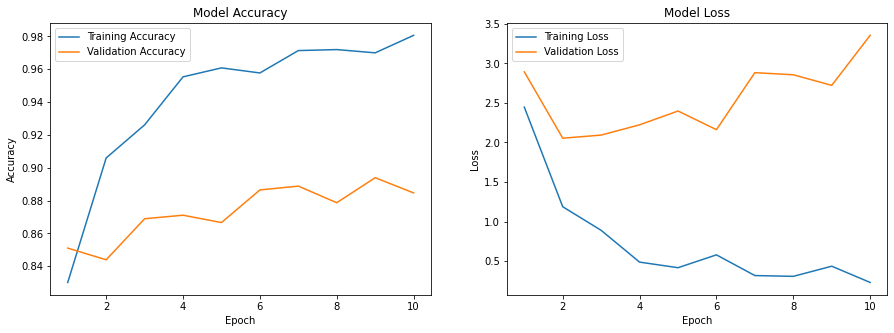

In [6]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    
    # Summarizing history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['Training Accuracy', 'Validation Accuracy'], loc='best')
    
    # Summarizing history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['Training Loss', 'Validation Loss'], loc='best')
    plt.show()

plot_model_history(history)

# 4. Output Prediction and Evaluation


In [8]:
label_predict = model.predict(pix_val)
# print(label_predict)
label_predict = np.argmax(model.predict(pix_val), axis=1)  # returns class values between 0 and 3 from highest prediction
# print(label_predict)
label_true = np.argmax(label_val, axis=1) 
# print(label_true)

target_names = ['other (0)', 'pylorus (1)', 'z-line (2)','retroflex-stomach (3)']
print("Classification report:\n", classification_report(label_true, label_predict, target_names=target_names))

Classification report:
                        precision    recall  f1-score   support

            other (0)       0.84      0.63      0.72      1332
          pylorus (1)       0.99      0.99      0.99      1777
           z-line (2)       0.74      0.89      0.80      1595
retroflex-stomach (3)       0.99      1.00      1.00      1337

             accuracy                           0.88      6041
            macro avg       0.89      0.88      0.88      6041
         weighted avg       0.89      0.88      0.88      6041



### 4.1. Confusion Matrix

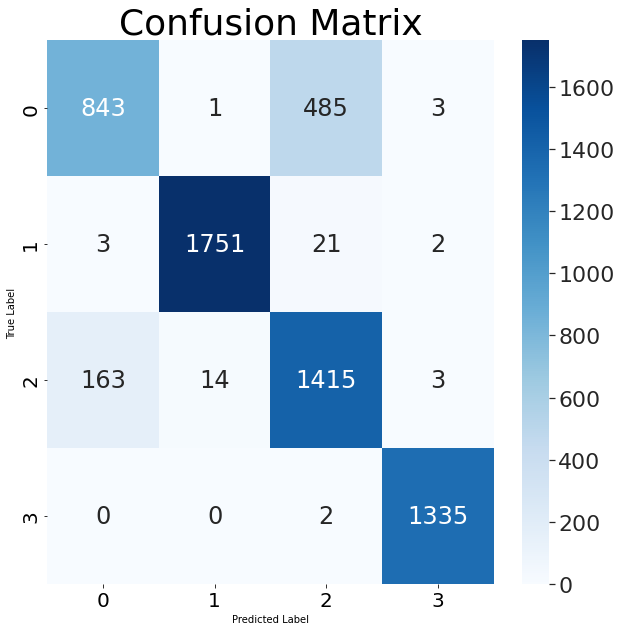

In [9]:
# Evaluating the CNN model by creating a confusion matrix
cm = confusion_matrix(label_true, label_predict)

plt.figure(figsize=(10,10))
ax = plt.subplot()

sbs.set(font_scale=2) 
sbs.heatmap(cm, annot=True, ax=ax, cmap="Blues", fmt="g");  

# Labels, title and ticks
ax.set_xlabel('Predicted Label');
ax.set_ylabel('True Label');

title_font = {'size':'36'}  
ax.set_title('Confusion Matrix', fontdict=title_font);

ax.tick_params(axis='both', which='major', labelsize=20) 
ax.xaxis.set_ticklabels(['0', '1', '2','3']);
ax.yaxis.set_ticklabels(['0', '1', '2','3']);
plt.show()